<a href="https://colab.research.google.com/github/erenonaran/deeplearning/blob/main/03_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import random
import time

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train_data = datasets.FashionMNIST(root="data",train=True,download=True,transform=ToTensor(),target_transform=None)
test_data = datasets.FashionMNIST(root="data",train=False,download=True,transform=ToTensor(),target_transform=None)


In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
print(train_data[0][0].shape)
print(len(train_data[0])) #tuple of length 2, image and label
image, label = train_data[0]
classes = train_data.classes
print(classes)
print(train_data.class_to_idx)

torch.Size([1, 28, 28])
2
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


(-0.5, 27.5, 27.5, -0.5)

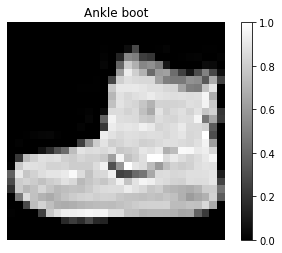

In [ ]:
plt.imshow(image.squeeze(),cmap="gray")
plt.colorbar()
plt.title(classes[label])
plt.axis(False)

In [ ]:
def plot_imgs(imgs:list,ncols:int,classes:list=None):
  fig = plt.figure(figsize=(8,8))
  nrows = ceil(len(imgs)/ncols)
  
  for img_idx, img in enumerate(imgs,start=1):
    ax = fig.add_subplot(nrows,ncols,img_idx)
    if classes != None:
      ax.imshow(img[0].squeeze(),cmap="gray")
      ax.set_title(classes[img[1]])
    else:
      ax.imshow(img.squeeze(),cmap="gray")
    ax.axis(False)
  
  plt.tight_layout()

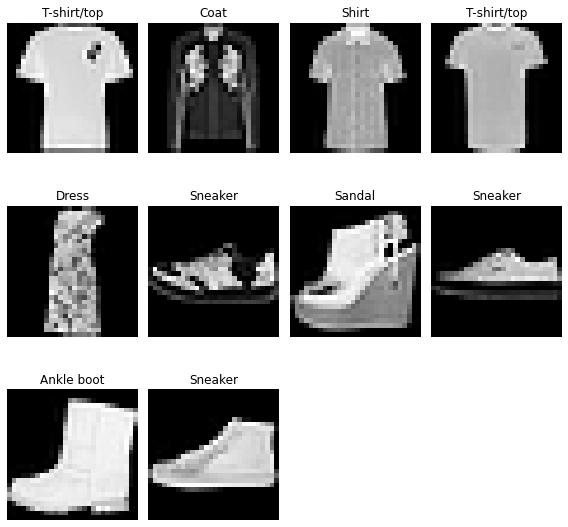

In [ ]:
plot_imgs(imgs=random.choices(train_data,k=10),ncols=4,classes=train_data.classes)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data, batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32,shuffle=False)

batch_sample = next(iter(train_dataloader))#may cause memory leakage
print(batch_sample[0].shape)
print(batch_sample[1].shape)
print(len(train_dataloader))

torch.Size([32, 1, 28, 28])
torch.Size([32])
1875


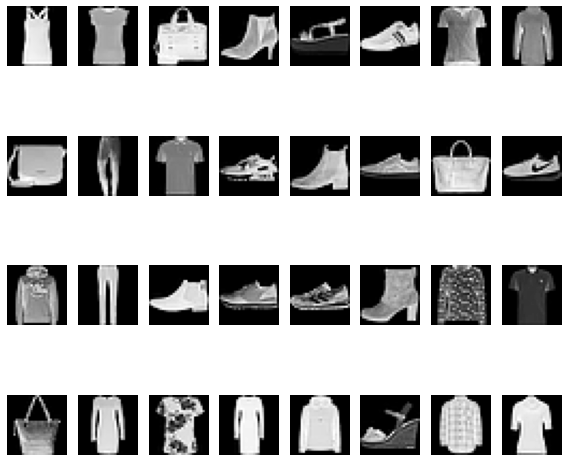

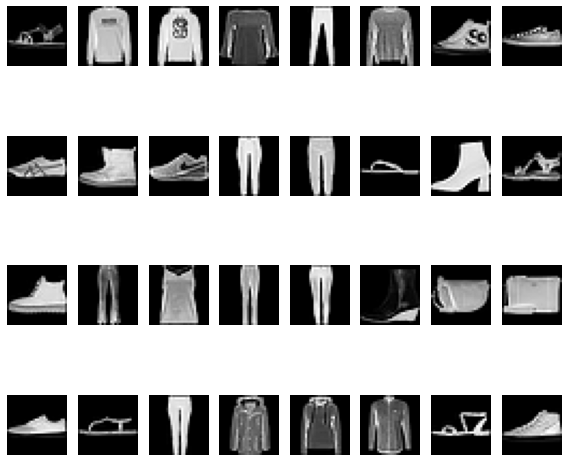

In [ ]:
dl = iter(train_dataloader)
for i in range(2):
  batched_train_data, batched_train_label = next(dl)
  plot_imgs(imgs=batched_train_data,ncols=8)
  

**Baseline Model**

We will start simple, and through experiment add complexity to our model, so that our computer vision problem can be solved.

In [ ]:
class FMNISTModelV0(nn.Module):

  def __init__(self,layer_neurons:tuple):
    super().__init__()
    n_layer = len(layer_neurons)-1
    self.layers = nn.Sequential(nn.Flatten(),
                                *[nn.Linear(layer_neurons[i],layer_neurons[i+1]) for i in range(n_layer)],
                                )
    
  def forward(self,x):
    return self.layers(x)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
n_input = image.flatten().shape[0]
n_output = len(train_data.classes)
model0 = FMNISTModelV0((n_input,16,n_output))

In [ ]:
model0

FMNISTModelV0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [ ]:
#Setting up loss function, optimizer and evaluation metrics
#Additionaly the patterns that model learns can be visualized by transforming tensors back into images

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),lr=0.1)

#Decorator for time evaluation
def time_eval(original_func):
  import time 
  def wrapper(*args,**kwargs):
    start = time.time()
    result = original_func(*args,**kwargs)
    stop = time.time()
    print(f"Execution time of {original_func.__name__!r}: {stop-start:.4f}'s")
    return result
  return wrapper

In [ ]:
from collections import Counter
print(train_data.targets)
train_targets_list = train_data.targets.tolist()
test_targets_list = test_data.targets.tolist()
print(Counter(train_targets_list))
print(Counter(test_targets_list))

tensor([9, 0, 0,  ..., 3, 0, 5])
Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
Counter({9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000})


In [ ]:
#Train and test datasets are balanced
#Accuracy is useful 
import torchmetrics

acc_fn = torchmetrics.Accuracy(task="multiclass",num_classes=len(train_data.classes))

In [ ]:

epoch = 3
start = time.time()
for epoch in range(epoch):
  print(f"Epoch: {epoch}")  
  train_loss = 0
  for batch,(X_train,y_train) in enumerate(train_dataloader):
    model0.train()
    y_train_logits = model0(X_train)
    loss_train = loss_fn(y_train_logits,y_train)
    train_loss += loss_train
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    if batch % 400 == 0:
      print(f"Looked at {batch*len(X_train)}/{len(train_dataloader.dataset)} samples")
  train_loss /= len(train_dataloader)
  test_loss = 0
  test_acc = 0
  model0.eval()
  with torch.inference_mode():
    for batch,(X_test,y_test) in enumerate(test_dataloader):
      y_test_logits = model0(X_test)
      loss_test = loss_fn(y_test_logits,y_test)
      test_loss += loss_test
      test_acc += acc_fn(y_test_logits.argmax(dim=1),y_test)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"Train loss: {train_loss} | Test loss: {test_loss} | Test acc: {test_acc}")
stop = time.time()
print(f"Execution time: {stop-start:.4f}'s")

Epoch: 0
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.5865006446838379 | Test loss: 0.5655045509338379 | Test acc: 0.7975239753723145
Epoch: 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.4731343388557434 | Test loss: 0.5563770532608032 | Test acc: 0.8036141991615295
Epoch: 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.4542078971862793 | Test loss: 0.5124269723892212 | Test acc: 0.8211861252784729
Execution time: 31.9903's


In [ ]:
@time_eval
def model_eval(model,dataloader,loss_fn,acc_fn,device=device):
  test_loss = 0
  test_acc = 0
  model.to(device)
  acc_fn.to(device)
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_test_logits = model(X_test)
      test_loss += loss_fn(y_test_logits, y_test)
      test_acc += acc_fn(y_test_logits.argmax(dim=1),y_test)
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return {"model_name":model.__class__.__name__,"device":next(model.parameters()).device,"test_loss":test_loss.item(),"test_acc":test_acc.item()}

In [ ]:
print(model_eval(model0,test_dataloader,loss_fn,acc_fn,"cpu"))

Execution time of 'model_eval': 0.9479's
{'model_name': 'FMNISTModelV0', 'device': device(type='cpu'), 'test_loss': 0.5124269723892212, 'test_acc': 0.8211861252784729}


In [ ]:
#Visualization of learned patterns for first layer

def patterns_as_imgs(model,size):
  model.cpu()
  fig = plt.figure(figsize=(30,30))

  parameters = model.parameters()
  first_layer_weights = next(parameters).detach().numpy()
  first_layer_biases = next(parameters).detach().numpy()

  nrows = ceil(len(first_layer_weights)/3)
  for weights_idx,weights in enumerate(first_layer_weights):
    ax = fig.add_subplot(nrows,3,weights_idx+1,)

    tensor_2D = weights.reshape(size)
    ax.imshow(tensor_2D,cmap="RdBu",vmin=-0.5,vmax=0.5)

    ax.axis(False)
    ax.set_title(f"Bias: {first_layer_biases[weights_idx]:.4f}")
    
  plt.tight_layout()

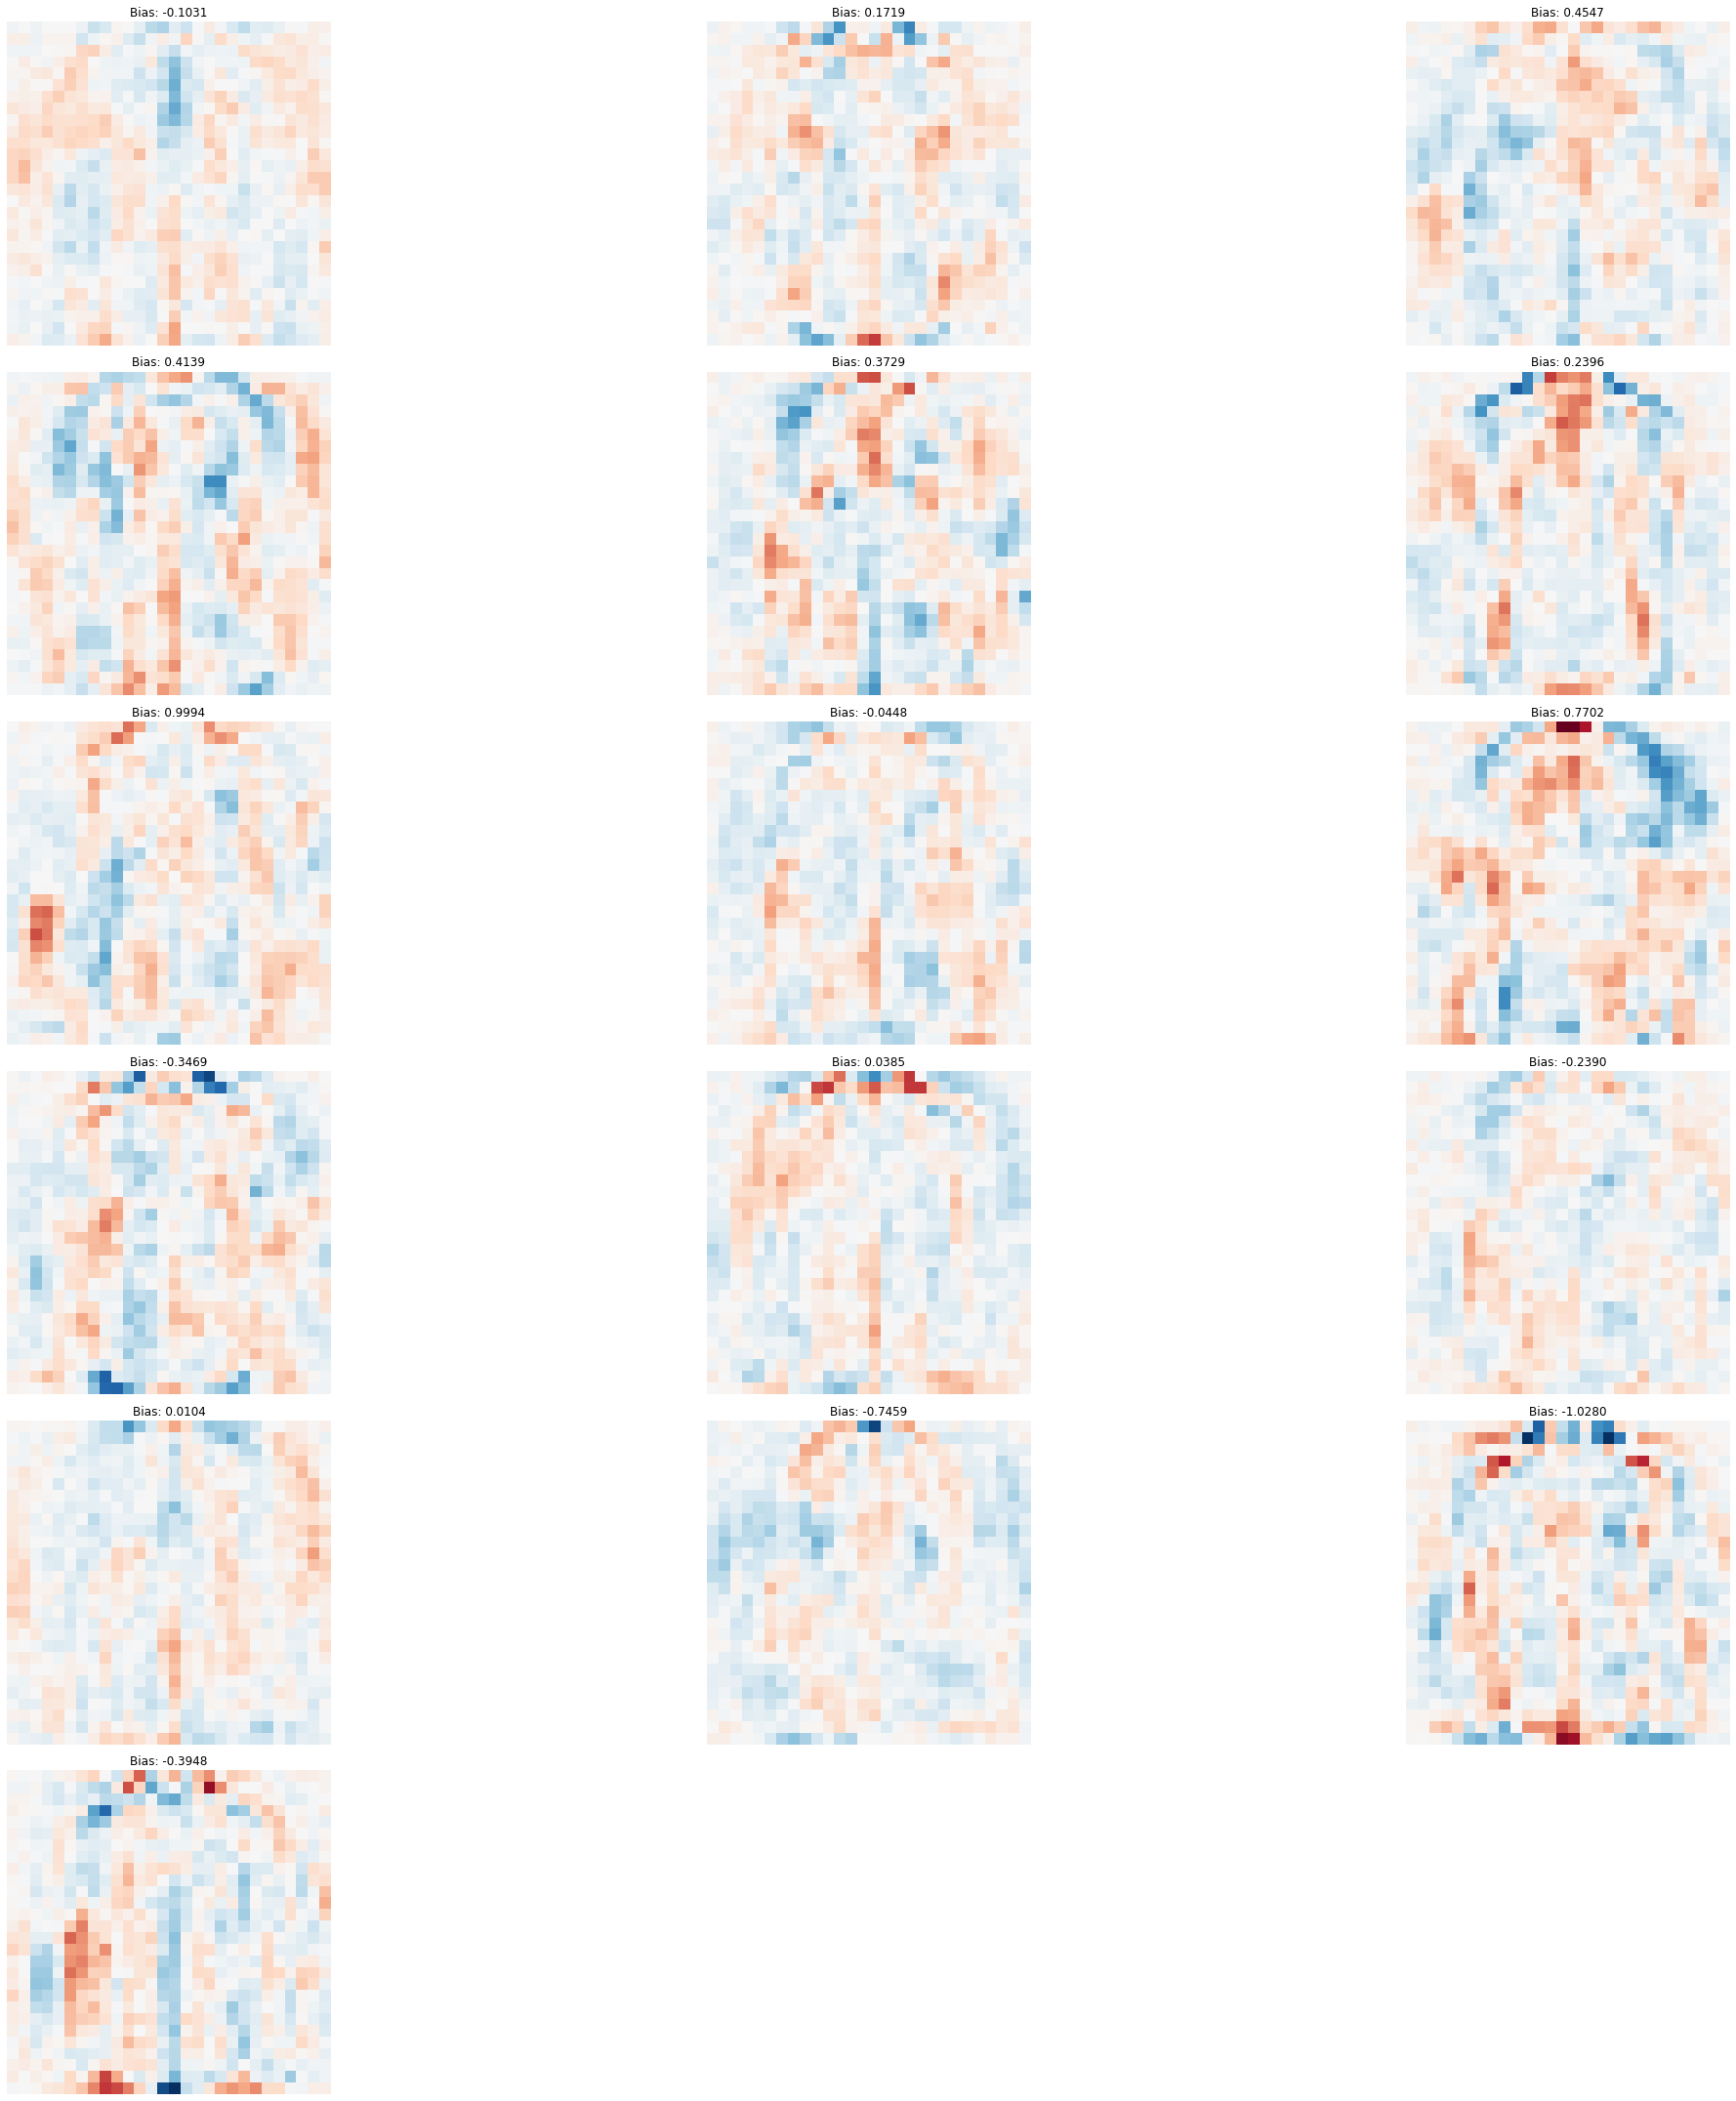

In [ ]:
patterns_as_imgs(model0,(28,28))

In [ ]:
class FMNISTModelV1(nn.Module):

  def __init__(self,layer_neurons:tuple):
    super().__init__()
    n_layer = len(layer_neurons)-1
    layer_list = []
    for i in range(n_layer):
      layer_list.extend([nn.Linear(layer_neurons[i],layer_neurons[i+1]),nn.ReLU()])
    #layer_list.pop(-1)

    self.layers = nn.Sequential(nn.Flatten(),
                                *layer_list,
                                )
    
  def forward(self,x):
    return self.layers(x)

In [ ]:
model1 = FMNISTModelV1((n_input,16,16,n_output))
model1

FMNISTModelV1(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=10, bias=True)
    (6): ReLU()
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),lr=0.1)
acc_fn = torchmetrics.Accuracy(task="multiclass",num_classes=len(train_data.classes))

In [ ]:

def train_step(model,train_dataloader,loss_fn,optimizer,acc_fn,device=device):
  model.to(device)
  acc_fn.to(device)
  train_loss,train_acc = 0, 0
  model.train()
  for X_train, y_train in train_dataloader:
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_train_logits = model(X_train)
    loss = loss_fn(y_train_logits,y_train)
    acc = acc_fn(y_train_logits.argmax(dim=1),y_train)
    train_loss += loss
    train_acc += acc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  print(f"Train loss: {train_loss} | Train acc: {train_acc}")
  return train_loss, train_acc


def test_step(model,test_dataloader,loss_fn,acc_fn,device=device):
  model.to(device)
  acc_fn.to(device)
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_test_logits = model(X_test)
      loss = loss_fn(y_test_logits,y_test)
      acc = acc_fn(y_test_logits.argmax(dim=1),y_test)
      test_loss += loss 
      test_acc += acc
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"Test loss: {test_loss} | Test acc: {test_acc}\n")
  return test_loss, test_acc


In [ ]:
epoch = 3 
start = time.time()
for epoch in range(epoch):
  print(f"Epoch: {epoch}")
  train_step(model1,train_dataloader,loss_fn,optimizer,acc_fn,device="cpu")
  test_step(model1,test_dataloader,loss_fn,acc_fn,device="cpu")
stop = time.time()
print(f"Execution time: {stop-start:.4f}'s")

Epoch: 0
Train loss: 1.236945629119873 | Train acc: 0.5814833045005798
Test loss: 1.1071449518203735 | Test acc: 0.6141173839569092

Epoch: 1
Train loss: 1.0738133192062378 | Train acc: 0.6237166523933411
Test loss: 1.07864248752594 | Test acc: 0.6204073429107666

Epoch: 2
Train loss: 1.0436427593231201 | Train acc: 0.6286333203315735
Test loss: 1.103087306022644 | Test acc: 0.6151158213615417

Execution time: 27.1598's


In [ ]:
model_eval(model1,test_dataloader,loss_fn,acc_fn)

Execution time of 'model_eval': 4.0613's


{'model_name': 'FMNISTModelV1',
 'device': device(type='cuda', index=0),
 'test_loss': 1.1030871868133545,
 'test_acc': 0.6151158213615417}

In [ ]:
class FMNISTModelV2(nn.Module):
  
  def __init__(self,input,hidden,output):
    super().__init__()
    self.conv_block1 = nn.Sequential(nn.Conv2d(in_channels=input,out_channels=hidden,kernel_size=3,stride=1,padding=1), 
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=3,stride=1,padding=1), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2,stride=2)) 
    self.conv_block2 = nn.Sequential(nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=3,stride=1,padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=3,stride=1,padding=1),
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2,stride=2)) 
    self.classifier = nn.Sequential(nn.Flatten(),
                               nn.Linear(in_features=hidden*49,out_features=output))
  

  def forward(self,x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classifier(x)
    return x 

In [ ]:
model2 = FMNISTModelV2(input=1,hidden=10,output=len(train_data.classes))
model2

FMNISTModelV2(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
print(image.unsqueeze(0).shape) #without unsqueeze(0), gives an error
with torch.inference_mode():
  logits = model2(image.unsqueeze(0))
print(logits)
print(logits.shape)

torch.Size([1, 1, 28, 28])
tensor([[ 0.0297, -0.0359,  0.0213, -0.0692,  0.0805, -0.0691, -0.0385, -0.0330,
         -0.0489, -0.0018]])
torch.Size([1, 10])


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model2.parameters(),lr=0.1)
acc_fn = torchmetrics.Accuracy(task="multiclass",num_classes=len(train_data.classes))

In [ ]:
epoch = 3
start = time.time()
for epoch in range(epoch):
  print(f"Epoch: {epoch}")

  train_step(model2,train_dataloader,loss_fn,optimizer,acc_fn,device=device)
  test_step(model2,test_dataloader,loss_fn,acc_fn,device=device)
stop = time.time()
print(f"Execution time: {stop-start:.4f}'s")

Epoch: 0
Train loss: 0.6966967582702637 | Train acc: 0.7475333213806152
Test loss: 0.40522733330726624 | Test acc: 0.8515375256538391

Epoch: 1
Train loss: 0.37178513407707214 | Train acc: 0.8655666708946228
Test loss: 0.35600489377975464 | Test acc: 0.8719049096107483

Epoch: 2
Train loss: 0.32701194286346436 | Train acc: 0.8822166919708252
Test loss: 0.3274603486061096 | Test acc: 0.8802915215492249

Execution time: 43.4265's


In [ ]:

test_list = random.choices(test_data, k=10)

def image_pred(model, test_list,classes=classes):
  images = [img for img,label in test_list]
  images_tensor = torch.stack(images,dim=0)
  labels = [label for img,label in test_list]
  
  model.cpu()
  fig = plt.figure(figsize=(15,15))

  model.eval()
  with torch.inference_mode():
    logits = model(images_tensor) #list of 1 28 28  --> tensor of 10 1 28 28
    pred_labels = logits.argmax(dim=1)
  
  for image_idx,image in enumerate(images):
    ax = fig.add_subplot(2,5,image_idx+1)
    ax.imshow(image.squeeze(),cmap="gray")
    ax.axis(False)

    if pred_labels[image_idx] == labels[image_idx]:
      ax.set_title(f"Pred: {classes[pred_labels[image_idx]]} | Truth: {classes[labels[image_idx]]}", c="green")
    else: 
      ax.set_title(f"Pred: {classes[pred_labels[image_idx]]} | Truth: {classes[labels[image_idx]]}",c="red")

  plt.tight_layout()

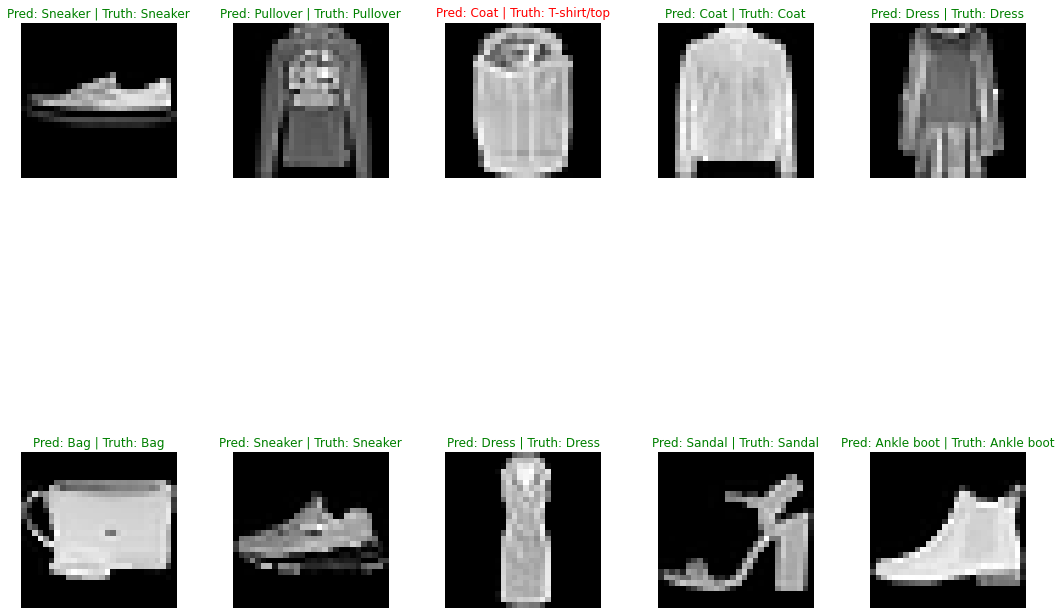

In [ ]:
image_pred(model2,test_list)

In [ ]:
#Images will be transformed (rotation, shifting, shrinking)
from torchvision import transforms

def transformed_image_pred(model, test_list,transform_list,classes=classes):
  images = [img for img,label in test_list]
  labels = [label for img,label in test_list]

  transformed_images = []
  for image in images:
    transform = random.choice(transform_list)
    transformed_image = transform(image)
    if transformed_image.shape == image.shape:
      transformed_images.append(transformed_image)
    else:
      transformed_image = transforms.Resize(image.shape[-1])(transformed_image)  #interpolation mode is bilinear defaultly
      transformed_images.append(transformed_image)
  transformed_images_tensor = torch.stack(transformed_images,dim=0)
  
  model.cpu()
  fig = plt.figure(figsize=(15,15))

  model.eval()
  with torch.inference_mode():
    logits = model(transformed_images_tensor) 
    pred_labels = logits.argmax(dim=1)
  
  for image_idx,image in enumerate(images):
    ax = fig.add_subplot(len(images),2,2*image_idx+1)
    ax_T = fig.add_subplot(len(images),2,2*image_idx+2)

    ax.imshow(image.squeeze(),cmap="gray")
    ax_T.imshow(transformed_images[image_idx].squeeze(),cmap="gray")

    ax.axis(False)
    ax_T.axis(False)

    if pred_labels[image_idx] == labels[image_idx]:
      ax.set_title(f"Pred: {classes[pred_labels[image_idx]]} | Truth: {classes[labels[image_idx]]}", c="green")
    else: 
      ax.set_title(f"Pred: {classes[pred_labels[image_idx]]} | Truth: {classes[labels[image_idx]]}",c="red")

  plt.tight_layout()

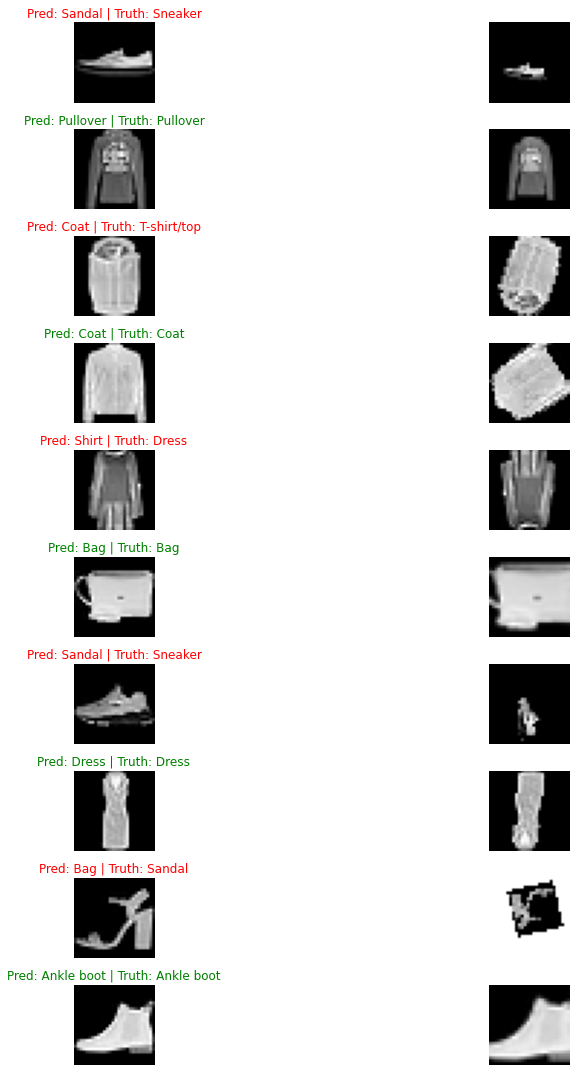

In [ ]:
transform_list = [transforms.RandomRotation(degrees=(0,180)),
                  transforms.RandomAffine(degrees=180, translate=(0.1, 0.3), scale=(0.5, 0.75)),
                  transforms.RandomAffine(degrees=180, translate=(0.1, 0.3), scale=(0.5, 0.75),fill=1.0),
                  transforms.Pad(padding=4),
                  transforms.CenterCrop(size=22)]

transformed_image_pred(model2,test_list,transform_list) 

In [ ]:
#Confusion Matrix 
import mlxtend
y_label_total = []

model2.to(device)
model2.eval()
with torch.inference_mode():
  for X_test, y_test in test_dataloader:
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    y_logits = model2(X_test)
    y_labels = y_logits.argmax(dim=1)
    y_label_total.append(y_labels.cpu())
y_label_total_tensor = torch.cat(y_label_total)



In [ ]:
try: 
  import torchmetrics, mlxtend
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

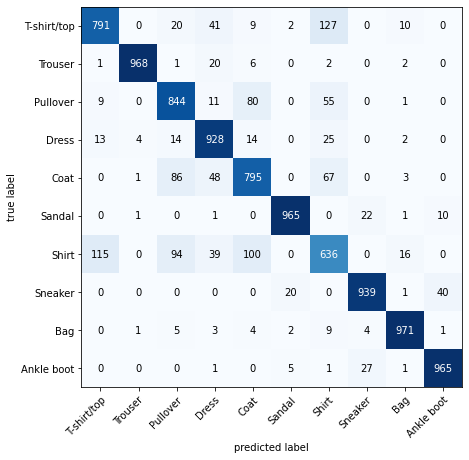

In [ ]:
conf_matrix = ConfusionMatrix(task="multiclass",num_classes=len(classes))
conf_matrix_tensor = conf_matrix(y_label_total_tensor, test_data.targets)

fig,ax = plot_confusion_matrix(conf_mat=conf_matrix_tensor.numpy(),class_names=classes,figsize=(10,7))